In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('Crude oil.csv')

In [3]:
df.info()
df.head()
df.columns
df.shape
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2548 non-null   object 
 1   Close/Last  2548 non-null   float64
 2   Volume      2517 non-null   float64
 3   Open        2548 non-null   float64
 4   High        2548 non-null   float64
 5   Low         2548 non-null   float64
dtypes: float64(5), object(1)
memory usage: 119.6+ KB


,0
Date,object
Close/Last,float64
Volume,float64
Open,float64
High,float64
Low,float64


In [4]:
df.isnull().sum()

,0
Date,0
Close/Last,0
Volume,31
Open,0
High,0
Low,0


In [5]:
df['Volume'] = df['Volume'].fillna(df['Volume'].median())
df.isnull().sum()

,0
Date,0
Close/Last,0
Volume,0
Open,0
High,0
Low,0


In [6]:
df.describe()

,Close/Last,Volume,Open,High,Low
count,2548.000000,2.548000e+03,2548.000000,2548.000000,2548.000000
mean,66.043740,3.950866e+05,66.042500,66.959839,65.065043
std,22.732093,2.331327e+05,22.710749,22.820487,22.565127
min,-37.630000,1.530000e+02,-37.250000,-35.200000,-40.320000
25%,48.620000,2.255235e+05,48.665000,49.317500,47.800000
50%,59.720000,3.638160e+05,59.770000,60.545000,58.850000
75%,87.467500,5.558335e+05,87.450000,88.695000,86.342500
max,123.700000,1.693652e+06,124.580000,129.440000,120.790000


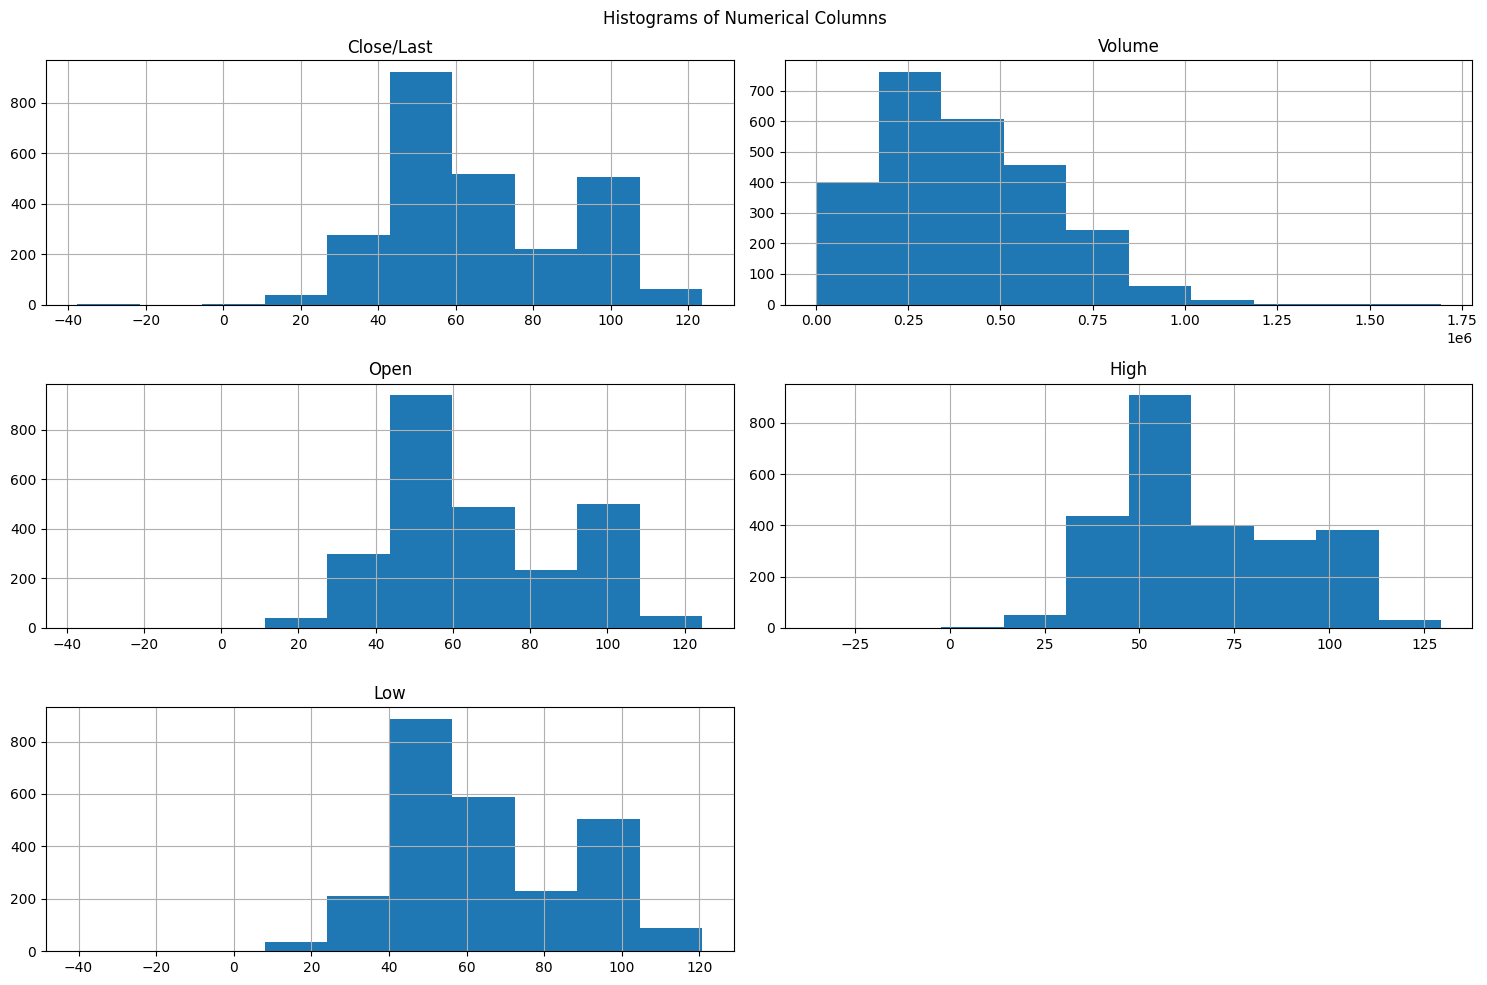

In [7]:
df.hist(figsize=(15, 10))
plt.suptitle("Histograms of Numerical Columns")
plt.tight_layout()
plt.show()

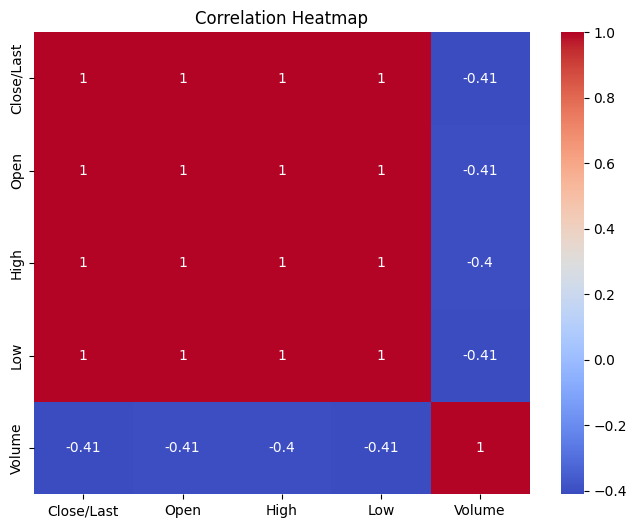

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Close/Last','Open','High','Low','Volume']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

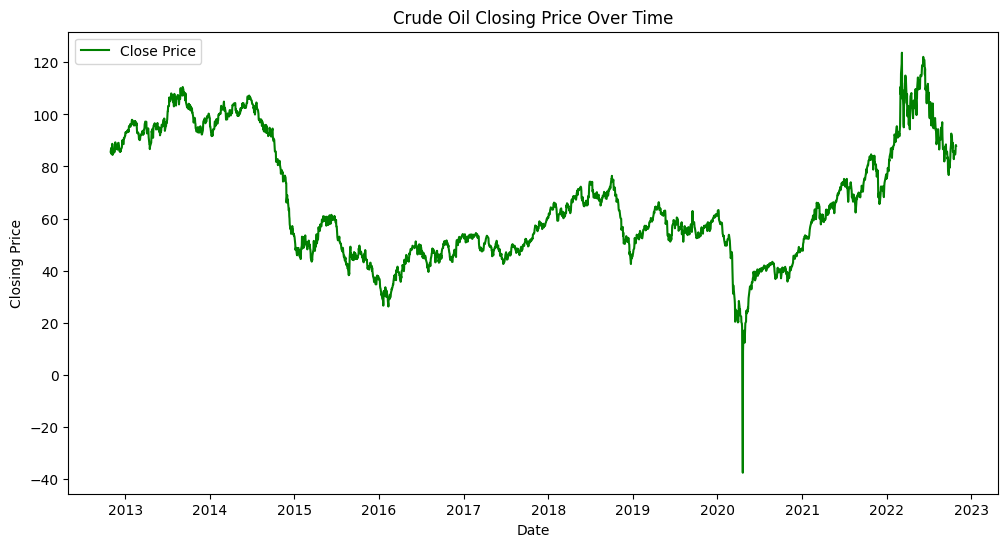

In [10]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close/Last'], label="Close Price", color="GREEN")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Crude Oil Closing Price Over Time")
plt.legend()
plt.show()

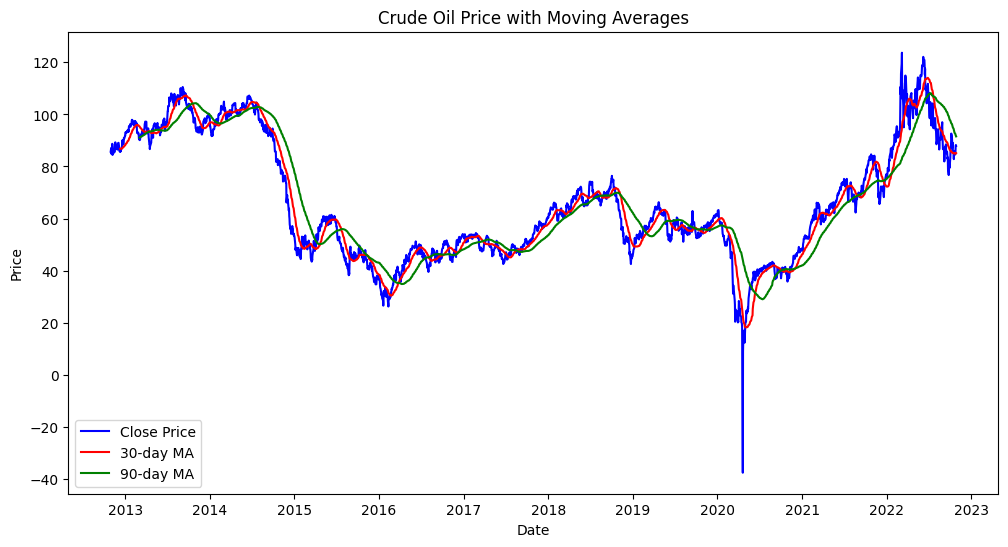

In [11]:
df['MA30'] = df['Close/Last'].rolling(30).mean()
df['MA90'] = df['Close/Last'].rolling(90).mean()
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close/Last'], label="Close Price", color="blue")
plt.plot(df['Date'], df['MA30'], label="30-day MA", color="red")
plt.plot(df['Date'], df['MA90'], label="90-day MA", color="green")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Crude Oil Price with Moving Averages")
plt.legend()
plt.show()


Outliers detected in Close/Last: 1 values

Outliers detected in Volume: 16 values

Outliers detected in Open: 1 values

Outliers detected in High: 1 values

Outliers detected in Low: 1 values


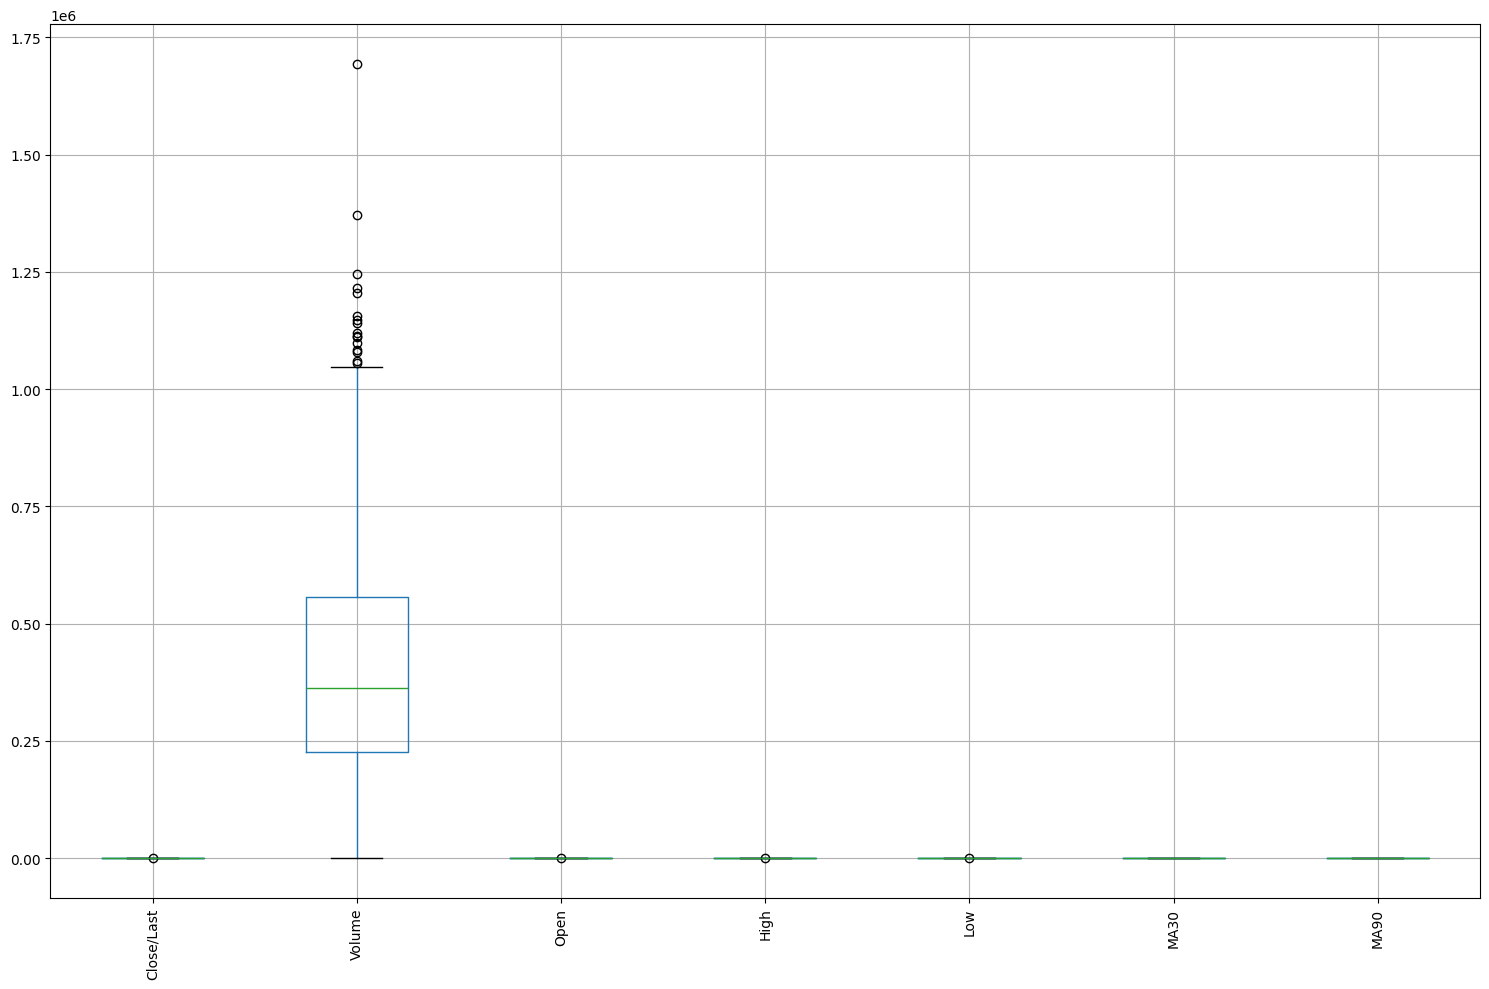

In [12]:
for col in ['Close/Last','Volume','Open','High','Low']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    print(f"\nOutliers detected in {col}: {len(outliers)} values")


df.boxplot(figsize=(15, 10))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
for col in ['Close/Last','Open','High','Low','Volume']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


print("Shape after removing outliers:", df.shape)

Shape after removing outliers: (2531, 8)


In [14]:
for col in ['Close/Last','Volume','Open','High','Low']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    print(f"\nOutliers detected in {col}: {len(outliers)} values")


Outliers detected in Close/Last: 0 values

Outliers detected in Volume: 0 values

Outliers detected in Open: 0 values

Outliers detected in High: 0 values

Outliers detected in Low: 0 values


In [15]:
##MODEL BUILDING

In [16]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

In [17]:
# Feature Engineering
df['MA7'] = df['Close/Last'].rolling(window=7).mean()
df['MA30'] = df['Close/Last'].rolling(window=30).mean()
df['Return1'] = df['Close/Last'].pct_change()
df['Lag1'] = df['Close/Last'].shift(1)
df['Lag7'] = df['Close/Last'].shift(7)

In [18]:
df = df.dropna().reset_index(drop=True)

In [19]:
# Features and Target
feature_cols = ['Open', 'High', 'Low', 'Volume', 'MA7', 'MA30', 'Return1', 'Lag1', 'Lag7']
X = df[feature_cols]
y = df['Close/Last']
dates = df['Date']

In [20]:
# Time-aware Split
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
dates_train, dates_test = dates.iloc[:train_size], dates.iloc[train_size:]

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, "scaler_oil.pkl")

['scaler_oil.pkl']

In [22]:
# Helper functions
def print_regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}


def plot_predictions(dates, y_true, y_pred, title):
    plt.figure(figsize=(12,5))
    plt.plot(dates, y_true, label="Actual")
    plt.plot(dates, y_pred, label="Predicted")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.show()

Linear Regression:
RMSE: 0.8658 | MAE: 0.6026 | R2: 0.9979


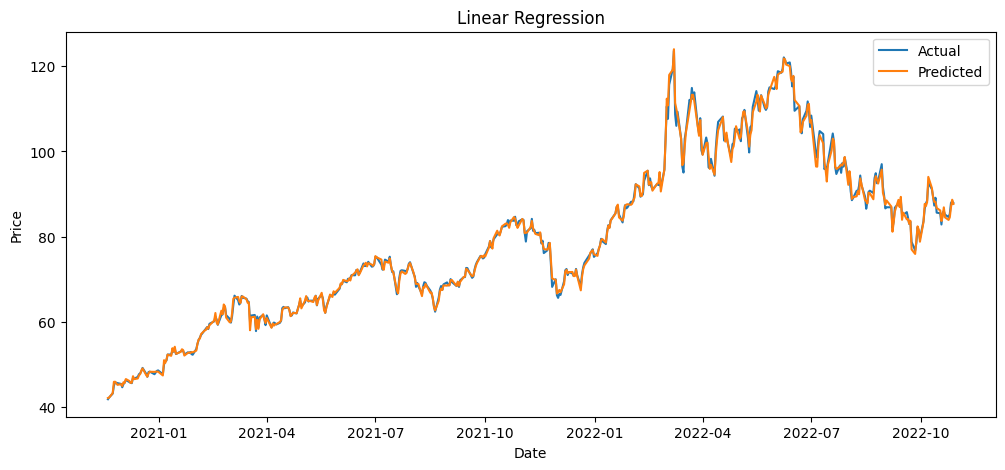

In [23]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Linear Regression:")
metrics_lr = print_regression_metrics(y_test, y_pred_lr)
plot_predictions(dates_test, y_test, y_pred_lr, "Linear Regression")

Random Forest:
RMSE: 2.1786 | MAE: 1.1690 | R2: 0.9866


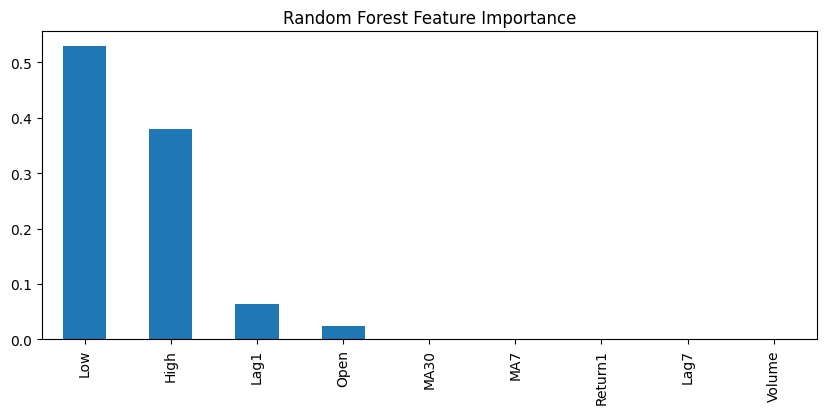

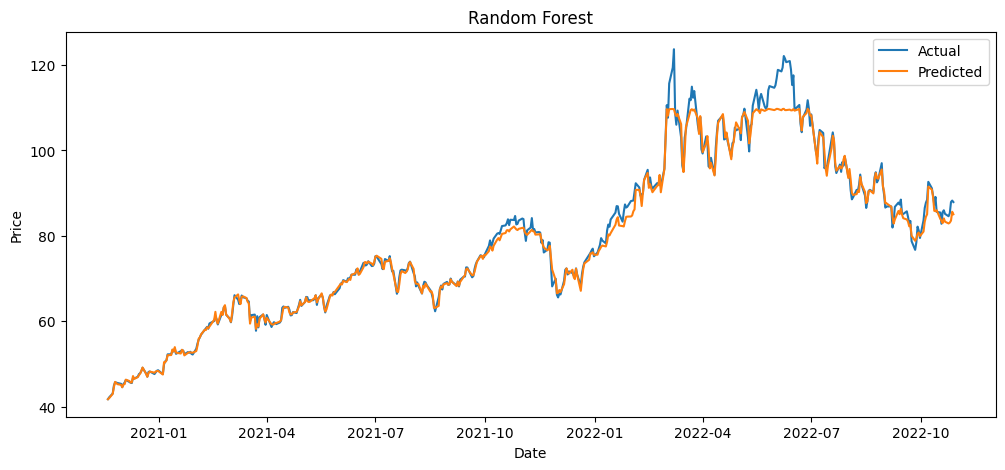

In [24]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:")
metrics_rf = print_regression_metrics(y_test, y_pred_rf)
pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title("Random Forest Feature Importance")
plt.show()
plot_predictions(dates_test, y_test, y_pred_rf, "Random Forest")

SVR:
RMSE: 6.4935 | MAE: 2.9325 | R2: 0.8813


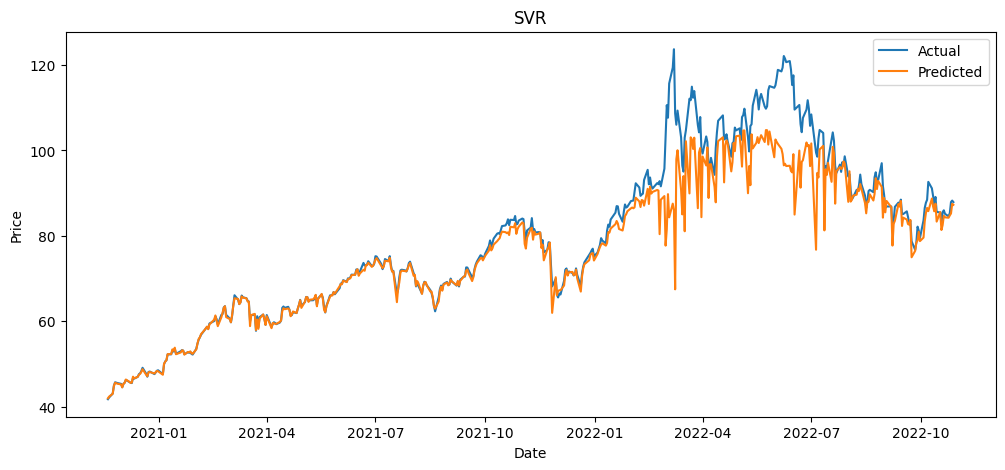

In [25]:
# SVR
svr = SVR(kernel='rbf', C=1.0, epsilon=0.01)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
print("SVR:")
metrics_svr = print_regression_metrics(y_test, y_pred_svr)
plot_predictions(dates_test, y_test, y_pred_svr, "SVR")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest:
RMSE: 2.2138 | MAE: 1.1977 | R2: 0.9862


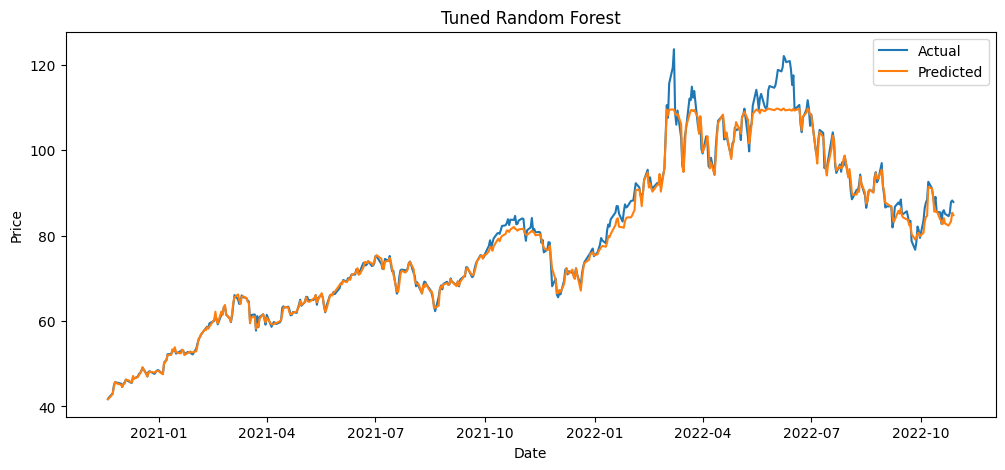

In [26]:
# Hyperparameter tuning for Random Forest
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {"n_estimators": [100, 200], "max_depth": [5, 10, None], "min_samples_split": [2, 5]}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv,
scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Tuned Random Forest:")
metrics_best_rf = print_regression_metrics(y_test, y_pred_best_rf)
plot_predictions(dates_test, y_test, y_pred_best_rf, "Tuned Random Forest")

In [27]:
# Model Comparison
candidates = {
"LinearRegression": (metrics_lr['r2'], lr, y_pred_lr),
"RandomForest": (metrics_rf['r2'], rf, y_pred_rf),
"SVR": (metrics_svr['r2'], svr, y_pred_svr),
"BestRF": (metrics_best_rf['r2'], best_rf, y_pred_best_rf)
}
best_name, (best_r2, best_model, best_pred) = max(candidates.items(), key=lambda x: x[1][0])
print(f"Best Model: {best_name} with R2 = {best_r2:.4f}")

Best Model: LinearRegression with R2 = 0.9979


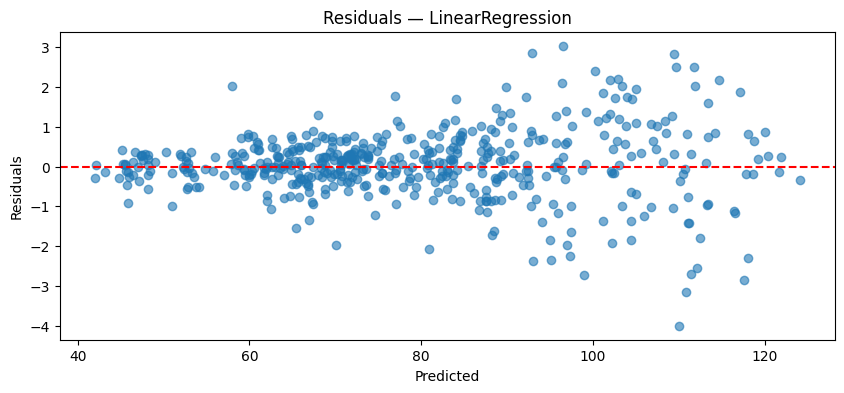

In [28]:
# Residuals
residuals = y_test.values - best_pred
plt.figure(figsize=(10,4))
plt.scatter(best_pred, residuals, alpha=0.6)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title(f"Residuals — {best_name}")
plt.show()

In [29]:
joblib.dump(best_model, "best_oil_model.pkl")
print("Model saved as best_oil_model.pkl")

Model saved as best_oil_model.pkl
